In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from omegaconf import OmegaConf
from models.flow_module import FlowModule
import torch
from data.pdb_dataloader import PdbDataModule
import glob
import GPUtil
from data import utils as du
import numpy as np
import tree
from data import so3_utils
from data import all_atom
from analysis import utils as au
from openfold.utils.superimposition import superimpose
import matplotlib.pyplot as plt
import pandas as pd
import plotnine as gg

In [3]:
save_dir = 'notebook_debug/'
num_timesteps = 100
os.makedirs(save_dir, exist_ok=True)

In [4]:
base_path = '../configs/base.yaml'

cfg = OmegaConf.load(base_path)
cfg.experiment.checkpointer.dirpath = './'
cfg.data.dataset.csv_path = '../preprocessed/metadata.csv'

flow = FlowModule(
    model_cfg=cfg.model,
    experiment_cfg=cfg.experiment
)

_ = flow.eval()

In [5]:
# Set up data module
data_module = PdbDataModule(cfg.data)
data_module.setup('fit')
train_dataloader = data_module.train_dataloader(
    num_replicas=1,
    rank=1
)
data_iter = iter(train_dataloader)


In [6]:
# Search for a reasonable batch
stop_search = False
while not stop_search: 
    batch = next(data_iter)
    num_batch, num_res, _ = batch['trans_1'].shape
    if num_res > 100:
        stop_search = True
print(f'Found batch with {num_res} residues, {num_batch} batch size')

# Set up device and cuda
num_batch, num_res, _ = batch['trans_1'].shape
cuda_id = GPUtil.getAvailable(order='memory', limit = 8)[0]
device = 'cpu'
print(f'Using device {device}')
flow.model = flow.model.to(device)
batch = tree.map_structure(lambda x: x.to(device), batch)

Found batch with 108 residues, 62 batch size
Using device cpu


In [7]:
# Take lots of samples
num_samples = 100
all_noisy_batches = [flow._corrupt_batch(batch) for _ in range(num_samples)]

all_t = du.to_numpy(torch.stack([x['t'] for x in all_noisy_batches]).reshape(-1))

all_rotmats_t = torch.stack([x['rotmats_t'] for x in all_noisy_batches]).reshape(-1, num_res, 3, 3)
all_rotmats_1 = torch.stack([x['rotmats_1'] for x in all_noisy_batches]).reshape(-1, num_res, 3, 3)
gt_rot_vf = so3_utils.calc_rot_vf(
    all_rotmats_t.type(torch.float32),
    all_rotmats_1.type(torch.float32)
)

In [13]:
rot_vf_mag = torch.linalg.norm(gt_rot_vf, dim=-1)
mag_max = rot_vf_mag.max()
mag_min = rot_vf_mag.min()
print(f'Max {mag_max}')
print(f'Min {mag_min}')

Max 3.1404056549072266
Min 0.002112212823703885


In [27]:
flat_ts = np.repeat(all_t[:, None], num_res, 1).flatten()
flat_mags = du.to_numpy(rot_vf_mag).flatten()

Text(0, 0.5, 'Rotation magnitude')

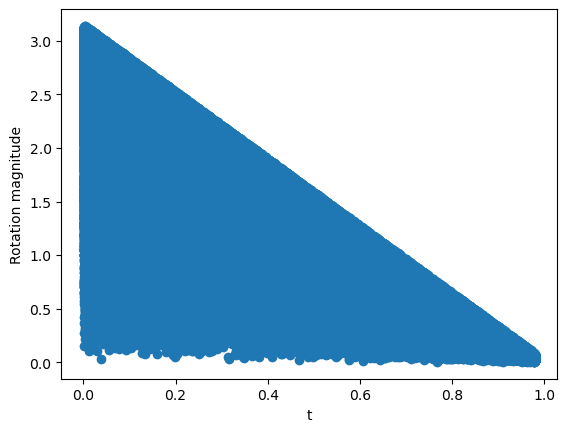

In [30]:
plt.scatter(flat_ts, flat_mags)
plt.xlabel('t')
plt.ylabel('Rotation magnitude')

Text(0, 0.5, 'count')

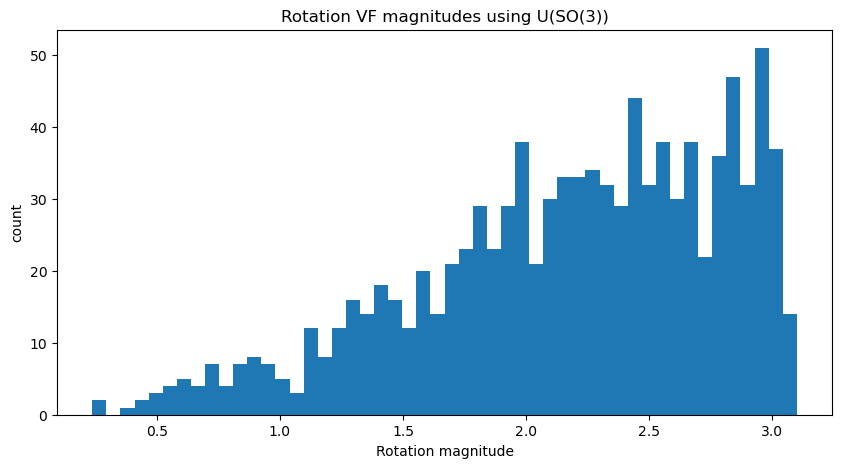

In [60]:
low_t_rot_mags = flat_mags[np.where(flat_ts < 0.05)][:1000]
plt.figure(figsize=(10, 5))
plt.hist(low_t_rot_mags, bins=50)
plt.title('Rotation VF magnitudes using U(SO(3))')
plt.xlabel('Rotation magnitude')
plt.ylabel('count')

In [33]:
sigma_grid = torch.linspace(0.1, 1.5, 1000)
igso3 = so3_utils.SampleIGSO3(1000, sigma_grid)

Computing igso3_expansion: 100%|██████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1660.67it/s]


In [35]:
igso3_samples = igso3.sample(torch.tensor([1.5]), 1000)

In [39]:
igso3_rotvec = so3_utils.rotmat_to_rotvec(igso3_samples[0])

In [40]:
igso3_norms = torch.linalg.norm(igso3_rotvec, dim=-1)

Text(0, 0.5, 'count')

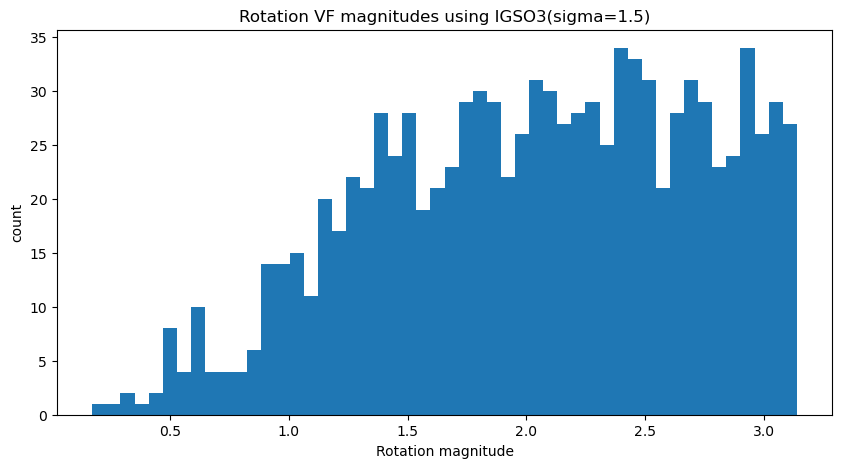

In [59]:
plt.figure(figsize=(10, 5))
plt.hist(igso3_norms, bins=50)
plt.title('Rotation VF magnitudes using IGSO3(sigma=1.5)')
plt.xlabel('Rotation magnitude')
plt.ylabel('count')